In [80]:
import os
import glob
import random
import numpy as np

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

In [10]:
ROOT = os.path.join(os.getcwd(),'img')
img_folders = {
    'clown':os.path.join(ROOT,'clown'),
    'reef':os.path.join(ROOT,'reef')
}

# Image cleaning

In [11]:
import string
import random

def random_string(min_char=8,max_char=None):
    if max_char is None:
        max_char = min_char
    allchar = string.ascii_letters + string.digits
    return "".join(random.choice(allchar) for x in range(random.randint(min_char, max_char)))

In [28]:
import uuid
uuid.uuid4().hex

'03b0d27fbabc4170b98f149771851528'

In [29]:
import os
import time

def rename(folder,new_name,start=1,prefix='',suffix=''):
    temp = random_string()
    # Use temp name first to avoid overwriting
    for k,img in enumerate(os.listdir(folder),start):
        os.rename(
            '{f}/{i}'.format(f=folder,i=img),
            '{f}/{t}{k:03d}'.format(f=folder,t=temp,k=k)
        )
        time.sleep(0.01)

    for k,img in enumerate(os.listdir(folder),start):
        os.rename(
            '{f}/{i}'.format(f=folder,i=img),
            '{f}/{p}{n}{k:03d}{s}'.format(f=folder,p=prefix,n=new_name,k=k,s=suffix)
        )
        time.sleep(0.01)

In [43]:
rename(img_folders['clown'],'clown',suffix='.png')

In [44]:
rename(img_folders['reef'],'reef',suffix='.png')

# Resize image

In [45]:
from PIL import Image

In [46]:
def custom_resize(img,max_size=600):
    (width, height) = img.size
    RATIO = min(min(max_size/width,1),min(max_size/height,1))
    new_size = (int(width*RATIO),int(height*RATIO))
    img = img.resize(new_size)
    return img

In [47]:
def resize(img_path,output_path=None,max_size=600):
    if output_path is None:
        output_path = img_path
    original_image = Image.open(img_path)
    new_image = custom_resize(original_image,max_size)
    new_image.save(output_path)

In [48]:
path = img_folders['clown']
for img in os.listdir(path):
    try:
        resize(path+'/'+img)
    except:
        print(img)

.DS_Store


# Image to 3D matrices

It has been shown that RGB is better suited than other color spaces for common applications. So we will stick to RGB

In [49]:
import numpy as np
import scipy

In [50]:
def normalized_image(img_path):
    return scipy.misc.imread(img_path)/255

example = normalized_image('/Users/Alex/Google Drive/GitHub/FishNet/img/clown/clown001.png')

AttributeError: module 'scipy' has no attribute 'misc'

# All in one loading and preprocessing

In [11]:
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [121]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]


train_transforms = transforms.Compose([transforms.Scale(size = 224),
                                       transforms.CenterCrop(size=224),
                                       transforms.ToTensor(),
                                       ])

# change root to valid dir in your system, see ImageFolder documentation for more info
dataset = datasets.ImageFolder(root=ROOT,
                                    transform=train_transforms)

In [122]:
N = round(len(dataset)*0.7)
indices = list(range(len(dataset)))
train_ids = np.random.choice(indices,size=N,replace=False)
test_ids = list(set(indices) - set(train_ids))

In [124]:
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_ids)
test_sampler = SubsetRandomSampler(test_ids)

In [162]:
trainset = DataLoader(dataset=dataset,
                      batch_size=8,
                      #shuffle=True,
                      sampler = train_sampler
                      #collate_fn=my_collate # use custom collate function here
                      )
testset = DataLoader(dataset=dataset,
                      batch_size=2,
                        #shuffle=True,
                      sampler = test_sampler
                      )

trainiter = iter(trainset)
imgs, labels = trainiter.next()

1


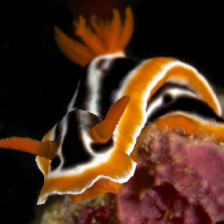

In [140]:
example = imgs[1]
print(labels[1])
transforms.ToPILImage()(example)

# Training part

# Define network

In [22]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [23]:
def abs_size(x):
    S = x.size()
    result = 1
    for s in S[1:]:
        result *= s
    return result

In [28]:
class FishNet(nn.Module):
    def __init__(self,number_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.apool = nn.AdaptiveAvgPool2d(16)
        self.fc1 = nn.Linear(16 * 16 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, number_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.apool(x)
        x = x.view(-1, abs_size(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


mynet = FishNet(2)
mynet

FishNet (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (apool): AdaptiveAvgPool2d (output_size=16)
  (fc1): Linear (4096 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 2)
)

## Optimizer

In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mynet.parameters(), lr=0.001, momentum=0.9)

LOSSES = []

## Train step

In [184]:
print_batch = 5
N_epoch = 2

for epoch in range(N_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainset, 1):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mynet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % print_batch == 0:    # print every 20 mini-batches
            LOSSES.append(running_loss/print_batch)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i , running_loss / print_batch))
            running_loss = 0.0
            
print('Finished Training')

[1,     5] loss: 0.000
[1,    10] loss: 0.000
[1,    15] loss: 0.000
[1,    20] loss: 0.000
[1,    25] loss: 0.000
[1,    30] loss: 0.000
[1,    35] loss: 0.000
[2,     5] loss: 0.000
[2,    10] loss: 0.000
[2,    15] loss: 0.000
[2,    20] loss: 0.000
[2,    25] loss: 0.000
[2,    30] loss: 0.000
[2,    35] loss: 0.000
Finished Training


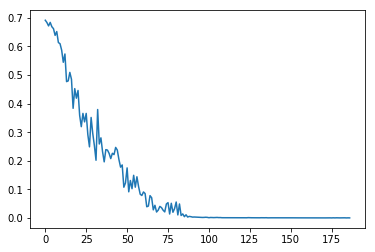

In [189]:
import matplotlib.pyplot as plt
plt.plot(LOSSES)
plt.show()

## test step

In [190]:
errors = 0
for i, data in enumerate(testset):
    inputs, labels = data
    inputs, labels = Variable(inputs), Variable(labels)
    outputs = mynet(inputs)
    _,y = torch.max(outputs,1)
    errors +=a
    
errors

Variable containing:
 0
[torch.ByteTensor of size 1]